In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
from math import sin, cos, sqrt, atan2, radians

Populating the interactive namespace from numpy and matplotlib


In [4]:
# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
horario_omnibus_por_paradas_ = pd.read_csv('files/uptu_pasada_variante.csv',sep=';')
horario_omnibus_por_paradas_.head()

,tipo_dia,cod_variante,frecuencia,cod_ubic_parada,ordinal,hora,dia_anterior
0,1,7929,9230,6301,1,923,N
1,1,7929,9230,6196,2,924,N
2,1,7929,9230,2315,3,925,N
3,1,7929,9230,2316,4,926,N
4,1,7929,9230,2317,5,926,N


In [5]:
# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
stops_ubication = gpd.read_file('files/v_uptu_paradas.shx')
stops_ubication = pd.DataFrame(stops_ubication)
stops_ubication.head()
#stops_ubication.query('COD_UBIC_P ==2447 and COD_VARIAN==1276' )
#stops_ubication.query('COD_UBIC_P ==4212 and COD_VARIAN==170' )

,COD_UBIC_P,DESC_LINEA,COD_VARIAN,ORDINAL,CALLE,ESQUINA,COD_CALLE1,COD_CALLE2,X,Y,geometry
0,546.0,144,883,43,CORUÃA,PURIFICACION,2187,5733,578023.60011,6.140711e+06,POINT (578023.60011 6140711.3452)
1,546.0,144,3225,45,CORUÃA,PURIFICACION,2187,5733,578023.60011,6.140711e+06,POINT (578023.60011 6140711.3452)
2,547.0,144,883,44,CORUÃA,SAN ANTONIO,2187,6279,577944.25345,6.140829e+06,POINT (577944.25345 6140828.51804)
3,547.0,144,3225,46,CORUÃA,SAN ANTONIO,2187,6279,577944.25345,6.140829e+06,POINT (577944.25345 6140828.51804)
4,548.0,144,888,20,CORUÃA,SAN ANTONIO,2187,6279,577926.50589,6.140845e+06,POINT (577926.50589 6140844.77825)


In [6]:
# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
recorridos_omnibus = gpd.read_file('files/v_uptu_lsv.dbf')
recorridos_omnibus = pd.DataFrame(recorridos_omnibus)
recorridos_omnibus.head()

,GID,COD_LINEA,DESC_LINEA,ORDINAL_SU,COD_SUBLIN,DESC_SUBLI,COD_VARIAN,DESC_VARIA,geometry
0,16009404.0,0,LINEA CERO,1,0,SUBLINEA CERO,0,None,None
1,16009406.0,1,402,1,1,CIUDAD VIEJA - MALVIN,8,A,None
2,16009407.0,2,404,1,2,CJO.J.AMÃRICA - PCIO.DE LA LUZ,14,B,None
3,16009408.0,2,404,1,2,CJO.J.AMÃRICA - PCIO.DE LA LUZ,20,A,None
4,16009409.0,3,405,1,3,PEÃAROL - PARQUE RODÃ,24,B,None


In [7]:
# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
ubicacion_puntos_control = gpd.read_file('files/v_uptu_controles.dbf')
ubicacion_puntos_control = pd.DataFrame(ubicacion_puntos_control)
ubicacion_puntos_control.head()

,COD_UBIC_C,DESC_LINEA,COD_VARIAN,ORDINAL,DESC_UBIC_,COD_CALLE1,COD_CALLE2,X,Y,geometry
0,1,402,1,10,MALVIN,7569,240,581831.105002,6.138254e+06,None
1,1,G,3401,2,MALVIN,7569,240,581831.105002,6.138254e+06,None
2,1,G,3402,11,MALVIN,7569,240,581831.105002,6.138254e+06,None
3,1,2,7565,2,MALVIN,7569,240,581831.105002,6.138254e+06,None
4,1,2,7566,8,MALVIN,7569,240,581831.105002,6.138254e+06,None


In [8]:
# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
origen_destino_lineas = gpd.read_file('files/v_uptu_lsv_destinos.dbf')
origen_destino_lineas = pd.DataFrame(origen_destino_lineas)
origen_destino_lineas.head()

,GID,COD_LINEA,DESC_LINEA,ORDINAL_SU,COD_SUBLIN,DESC_SUBLI,COD_VARIAN,DESC_VARIA,COD_VAR_01,COD_ORIGEN,DESC_ORIGE,COD_DESTIN,DESC_DESTI,geometry
0,16009406.0,1,402,1,1,CIUDAD VIEJA - MALVIN,8,A,NaN,19,PLAYA MALVÃN,23,CIUDAD VIEJA,None
1,16009407.0,2,404,1,2,CJO.J.AMÃRICA - PCIO.DE LA LUZ,14,B,NaN,69,PALACIO DE LA LUZ,47,COMPLEJO JUANA DE AMÃRICA,None
2,16009408.0,2,404,1,2,CJO.J.AMÃRICA - PCIO.DE LA LUZ,20,A,NaN,47,COMPLEJO JUANA DE AMÃRICA,69,PALACIO DE LA LUZ,None
3,16009409.0,3,405,1,3,PEÃAROL - PARQUE RODÃ,24,B,NaN,56,PARQUE RODÃ,74,PEÃAROL,None
4,16009410.0,3,405,2,246,GRUTA DE LOURDES - PARQUE RODO,28,B,NaN,56,PARQUE RODÃ,5,GRUTA DE LOURDES,None


In [9]:
# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
recorridos_variantes_no_maximales = gpd.read_file('files/uptu_variante_no_maximal.dbf')
recorridos_variantes_no_maximales = pd.DataFrame(recorridos_variantes_no_maximales)
recorridos_variantes_no_maximales.head()

#stops_ubication.query('COD_UBIC_P ==2447 and COD_VARIAN==1276' )


,GID,COD_VARIAN,COD_VAR_01,DESC_VARIA,COD_UBIC_P,COD_UBI_01,ORDINAL_OR,ORDINAL_DE,geometry
0,46204183.0,5,1,B,6092.0,3252.0,50,73,None
1,46204184.0,6,1,B,3520.0,3252.0,30,73,None
2,46204185.0,7,1,B,4041.0,2912.0,1,66,None
3,46204186.0,15,14,B,3922.0,3207.0,1,39,None
4,46204187.0,17,14,B,6091.0,2474.0,40,47,None


In [10]:
# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
transfers = pd.read_csv('files/trasbordos.csv',sep=',')

#transfers['stop_line_1'] = transfers['stop_id_1'] + transfers['line_id_1'] 
transfers.head()


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers
0,2427,2426,1096,2579,309
1,1885,4468,1759,1667,204
2,1108,4775,1122,650,186
3,1942,4399,1759,987,165
4,4212,5709,170,2579,149


## comienza el procesameinto >>>>>>>>>>>>>>>>>>>>

SALIDA: que son??

4 3 //cantidad_de_lineas puntos_sincro

1 2 2 100 3 10 15 16 0 // linea1 linea2 dist_entre_paradas P wb Wb TTl1 TTl2 es_bachin

2 3 1  50 5  8 18 22 0

3 4 1  75 5  8 18 22 0

5 15

4 12

4 10

4 10


merge transfers with no maximal lines

In [89]:
transfers_with_no_max = transfers.copy()
transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                 how='left', left_on=['line_id_1'], right_on=['COD_VARIAN'])
transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                               'line_id_1','line_id_2','n_transfers',
                                              'COD_VAR_01',]]
transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                               'line_id_1','line_id_2','n_transfers',
                                              'line_id_1_var_01',]

transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                 how='left', left_on=['line_id_2'], right_on=['COD_VARIAN'])
transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                               'line_id_1','line_id_2','n_transfers','line_id_1_var_01',
                                              'COD_VAR_01',]]
transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                               'line_id_1','line_id_2','n_transfers',
                                              'line_id_1_var_01','line_id_2_var_01',]

display(transfers_with_no_max.head(20))

,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,2427,2426,1096,2579,309,NaN,1311.0
1,1885,4468,1759,1667,204,NaN,NaN
2,1108,4775,1122,650,186,NaN,NaN
3,1942,4399,1759,987,165,NaN,982.0
4,4212,5709,170,2579,149,NaN,1311.0
5,2447,2437,1276,1092,148,1274.0,NaN
6,1599,5709,1438,2579,142,1434.0,1311.0
7,2427,2426,1096,1290,136,NaN,1282.0
8,1942,4848,1759,2422,131,NaN,1736.0
9,4843,4930,1122,1347,128,NaN,NaN


complete maximals

In [90]:
transfers_with_no_max['line_id_1_var_01'] =\
            transfers_with_no_max.apply(lambda e: e.line_id_1 
                                        if math.isnan(e.line_id_1_var_01)
                                        else e.line_id_1_var_01,axis = 1) 
    
transfers_with_no_max['line_id_2_var_01'] =\
            transfers_with_no_max.apply(lambda e: e.line_id_2 
                                        if math.isnan(e.line_id_2_var_01) 
                                        else e.line_id_2_var_01,axis = 1) 

display(transfers_with_no_max.head(20))


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,2427,2426,1096,2579,309,1096.0,1311.0
1,1885,4468,1759,1667,204,1759.0,1667.0
2,1108,4775,1122,650,186,1122.0,650.0
3,1942,4399,1759,987,165,1759.0,982.0
4,4212,5709,170,2579,149,170.0,1311.0
5,2447,2437,1276,1092,148,1274.0,1092.0
6,1599,5709,1438,2579,142,1434.0,1311.0
7,2427,2426,1096,1290,136,1096.0,1282.0
8,1942,4848,1759,2422,131,1759.0,1736.0
9,4843,4930,1122,1347,128,1122.0,1347.0


merge transfers and stops ubication to get stops geometriy (coordinates)

In [103]:
transfers_with_stop_coors = transfers_with_no_max.copy()
transfers_with_stop_coors =  pd.merge(transfers_with_stop_coors, stops_ubication, 
                 how='left', left_on=['stop_id_1','line_id_1_var_01'], right_on=['COD_UBIC_P',
                                                                                 'COD_VARIAN'])


transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                       'stop_id_2','line_id_1_var_01',
                                                         'line_id_2_var_01','n_transfers','geometry']]



transfers_with_stop_coors.columns = ['line_id_1','line_id_2','stop_id_1','stop_id_2',
                                     'line_id_1_var_01','line_id_2_var_01','n_transfers',
                                      'line_1_geometry']


transfers_with_stop_coors = pd.merge(transfers_with_stop_coors, stops_ubication, 
                 how='left', left_on=['stop_id_2','line_id_2_var_01'], right_on=['COD_UBIC_P',
                                                                                 'COD_VARIAN'])


transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                       'stop_id_2','line_id_1_var_01',
                                                         'line_id_2_var_01','n_transfers',
                                                       'line_1_geometry','geometry']]

transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1',
                                                         'line_id_2','n_transfers',
                                                         'line_1_geometry',
                                                         'geometry']]
transfers_with_stop_coors.columns = ['line_id_1',
                                    'line_id_2','n_transfers','line_1_geometry',
                                    'line_2_geometry']
display(transfers_with_stop_coors)

,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134)
1,1759,1667,204,POINT (579143.19729 6151045.05149),POINT (579003.43819 6150897.89783)
2,1122,650,186,POINT (568274.43675 6140874.33485),POINT (568313.75044208 6140712.23252608)
3,1759,987,165,POINT (576647.11472 6148135.18576),POINT (576591.86934 6148055.24203)
4,170,2579,149,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392)
5,1276,1092,148,POINT (574419.2876644752 6142043.651997477),POINT (574338.72252 6141670.17293)
6,1438,2579,142,POINT (571906.546542 6142246.919004),POINT (571879.0758399999 6142165.71392)
7,1096,1290,136,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134)
8,1759,2422,131,POINT (576647.11472 6148135.18576),POINT (576793.9282862354 6147779.394846829)
9,1122,1347,128,POINT (568550.168073634 6140749.17301807),POINT (568630.045883108 6140710.86058456)


caculate distance between stops of lines

In [104]:
def dist(geometry_1,geometry_2):
    return geometry_1.distance(geometry_2)

transfers_with_stop_coors['dist'] =\
transfers_with_stop_coors.apply(lambda e:dist(e.line_1_geometry,e.line_2_geometry),axis = 1) 
transfers_with_stop_coors.head(20)

,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,dist
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),69.705854
1,1759,1667,204,POINT (579143.19729 6151045.05149),POINT (579003.43819 6150897.89783),202.945327
2,1122,650,186,POINT (568274.43675 6140874.33485),POINT (568313.75044208 6140712.23252608),166.801468
3,1759,987,165,POINT (576647.11472 6148135.18576),POINT (576591.86934 6148055.24203),97.175367
4,170,2579,149,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),107.064413
5,1276,1092,148,POINT (574419.2876644752 6142043.651997477),POINT (574338.72252 6141670.17293),382.069832
6,1438,2579,142,POINT (571906.546542 6142246.919004),POINT (571879.0758399999 6142165.71392),85.725755
7,1096,1290,136,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),69.705854
8,1759,2422,131,POINT (576647.11472 6148135.18576),POINT (576793.9282862354 6147779.394846829),384.891410
9,1122,1347,128,POINT (568550.168073634 6140749.17301807),POINT (568630.045883108 6140710.86058456),88.590671


intersection points

In [108]:
display(transfers_with_stop_coors.head())

points = transfers_with_stop_coors[['line_id_1','line_id_2','dist','n_transfers']]
points.columns = ['line_i','line_j','dist','demand']
#points['dist'] =  points.apply(lambda e:dist(e.x,e.y),axis = 1) 

points.insert(4, 'wb',np.zeros(len(points)))
points.insert(5, 'wB', np.zeros(len(points)))
points.insert(6, 'TT_i', np.zeros(len(points)))
points.insert(7, 'TT_j', np.zeros(len(points)))
points.insert(8, 'BP', np.zeros(len(points)))
points.head(20)

,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,dist
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),69.705854
1,1759,1667,204,POINT (579143.19729 6151045.05149),POINT (579003.43819 6150897.89783),202.945327
2,1122,650,186,POINT (568274.43675 6140874.33485),POINT (568313.75044208 6140712.23252608),166.801468
3,1759,987,165,POINT (576647.11472 6148135.18576),POINT (576591.86934 6148055.24203),97.175367
4,170,2579,149,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),107.064413


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1096,2579,69.705854,309,0.0,0.0,0.0,0.0,0.0
1,1759,1667,202.945327,204,0.0,0.0,0.0,0.0,0.0
2,1122,650,166.801468,186,0.0,0.0,0.0,0.0,0.0
3,1759,987,97.175367,165,0.0,0.0,0.0,0.0,0.0
4,170,2579,107.064413,149,0.0,0.0,0.0,0.0,0.0
5,1276,1092,382.069832,148,0.0,0.0,0.0,0.0,0.0
6,1438,2579,85.725755,142,0.0,0.0,0.0,0.0,0.0
7,1096,1290,69.705854,136,0.0,0.0,0.0,0.0,0.0
8,1759,2422,384.891410,131,0.0,0.0,0.0,0.0,0.0
9,1122,1347,88.590671,128,0.0,0.0,0.0,0.0,0.0


frequency

In [111]:
# list of used stops
aux_lines_i =  pd.DataFrame({'linea': points['line_i'] })
aux_lines_j =  pd.DataFrame({'linea': points['line_j'] })
aux_lines = aux_lines_i.append(aux_lines_j)
aux_lines = aux_lines.drop_duplicates(subset=None, keep='first', inplace=False)
frequency = aux_lines.copy()
frequency.insert(1, 'h', np.zeros(len(frequency)))
frequency.insert(2, 'H', np.zeros(len(frequency)))
frequency.head()

,linea,h,H
0,1096,0.0,0.0
1,1759,0.0,0.0
2,1122,0.0,0.0
4,170,0.0,0.0
5,1276,0.0,0.0


plotting

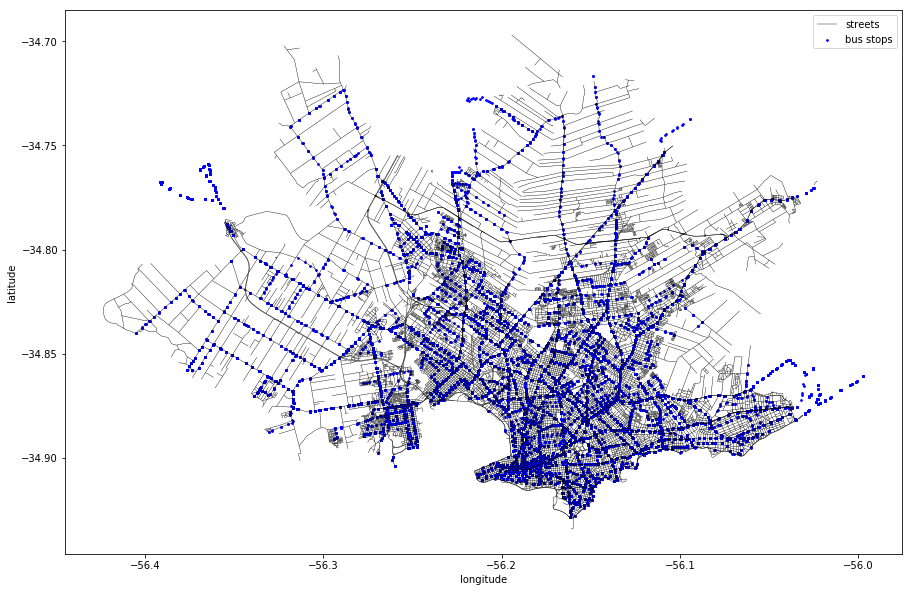

In [58]:

gdf_bus_stops=gpd.read_file("files/v_uptu_paradas/v_uptu_paradas.shp")
gdf_bus_stops=gdf_bus_stops.to_crs(epsg=4326) 

gdf_streets=gpd.read_file("files/v_mdg_vias/v_mdg_vias.shp")
gdf_streets=gdf_streets.to_crs(epsg=4326) 

fig, ax = plt.subplots(figsize=(15, 10))

gdf_streets.plot(ax=ax,
                linewidth=0.4,
                color="black",
                label="streets")


gdf_bus_stops.plot(ax=ax,
                   color="blue",
                markersize=3,
              label="bus stops")
plt.legend()
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.rcParams.update({'font.size': 12})

plt.savefig("figs/paradas_buses.png", bbox_inches='tight')

